## Imports Section: Importing Necessary Packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM , Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import os
import nbformat

## Setting Base Path for File Operations.

In [2]:
def set_base_path(base_path):
    """
    Set the base path for file operations.

    Parameters:
    - base_path (str): The base path to set.

    Returns:
    - None
    """
    global BASE_PATH
    BASE_PATH = base_path

def construct_file_path(relative_path):
    """
    Construct the full file path using the base path and the relative path.

    Parameters:
    - relative_path (str): The relative path from the base path.

    Returns:
    - full_path (str): The full file path.
    """
    if 'BASE_PATH' not in globals():
        raise ValueError("Base path is not set. Call set_base_path() first.")

    full_path = os.path.join(BASE_PATH, relative_path)
    return full_path

# usage
set_base_path(r"F:\DataScience\code\stock-prediction")

In [3]:
# Loading CNN Model Notebook.
def load_notebook(file_path):
    """
    Load a Jupyter Notebook file (.ipynb).

    Parameters:
    - file_path (str): The path to the .ipynb file.

    Returns:
    - notebook (NotebookNode): The loaded notebook object.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        notebook = nbformat.read(file, as_version=4)
    return notebook

# usage
file_path = construct_file_path("notebooks/CNN_Model.ipynb")
cnn_model_notebook = load_notebook(file_path)

## Ignore Warning.

In [4]:
import warnings
    
warnings.filterwarnings("ignore")

## Model Architecture: Reading DataFrames and display it.

In [5]:
# Construct the full file path for data/data.csv
file_path = construct_file_path("data/AAPL_use.csv")

# Now you can use file_path to read the CSV file
df = pd.read_csv(file_path)

print(df['Close'].shape)

(4027,)


In [6]:
# Removing %h-%m-%s From Date Column
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
print(df)

            Date        Open        High         Low       Close   Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571    5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929    5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286    5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643    5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286    5.643891   
...          ...         ...         ...         ...         ...         ...   
4022  23-10-2023  170.910004  174.009995  169.929993  173.000000  173.000000   
4023  24-10-2023  173.050003  173.669998  171.449997  173.440002  173.440002   
4024  25-10-2023  171.880005  173.059998  170.649994  171.100006  171.100006   
4025  26-10-2023  170.369995  171.380005  165.669998  166.889999  166.889999   
4026  27-10-2023  166.910004  168.960007  166.830002  168.220001  168.220001   

          Volume  
0      939414000  
1

In [7]:
# Checking The Type Of Data Column(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB


In [8]:
# Converting Object To Datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

## Plotting Date and Close Price.

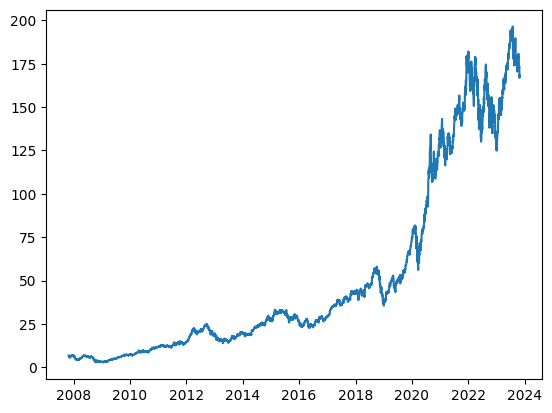

In [9]:
plt.plot(df['Date'],df['Close'])

In [10]:
print(df.shape)

(4027, 7)


## create a new dataframe with only the Close column.

In [11]:
data = df['Close'].values.reshape(-1, 1) # (rows , Columns)
print(data)

[[  6.678571]
 [  6.783929]
 [  6.694286]
 ...
 [171.100006]
 [166.889999]
 [168.220001]]


In [12]:
print(data.shape)

(4027, 1)


## Normalize the data.

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)
print(data_normalized)

[[0.02006491]
 [0.02060896]
 [0.02014606]
 ...
 [0.8690986 ]
 [0.84735911]
 [0.85422693]]


## Data Preparation: Converting an Array of Values into a Dataset Matrix.

In [14]:
def prepare_data(data, time_steps):
    """
    Prepare the data for sequence modeling by converting an array of values into a dataset matrix.

    Parameters:
    - data: The input data as a numpy array.
    - time_steps: The number of time steps to consider for each sample.

    Returns:
    - X: The input features matrix.
    - y: The target variable vector.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        """Extract a sequence of data points of length 'time_steps' as input features (X)."""
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
        if i <= 1:
            """Print the first few samples of X and y for debugging purposes."""
            print("X:", X)
            print("y:", y)
            print()
    return np.array(X), np.array(y)

time_steps = 10  
X, y = prepare_data(data_normalized, time_steps)

X: [array([0.02006491, 0.02060896, 0.02014606, 0.02022536, 0.01991369,
       0.02094829, 0.01993582, 0.01793855, 0.01607591, 0.01393479])]
y: [0.01692239697436408]

X: [array([0.02006491, 0.02060896, 0.02014606, 0.02022536, 0.01991369,
       0.02094829, 0.01993582, 0.01793855, 0.01607591, 0.01393479]), array([0.02060896, 0.02014606, 0.02022536, 0.01991369, 0.02094829,
       0.01993582, 0.01793855, 0.01607591, 0.01393479, 0.0169224 ])]
y: [0.01692239697436408, 0.016212379259551185]



In [15]:
X.shape

(4017, 10)

## Reshape the data.

In [16]:
X = np.reshape(X, (X.shape[0], X.shape[1] , 1))  
print(X.shape)

(4017, 10, 1)


In [17]:
print("X: ", X)

X:  [[[0.02006491]
  [0.02060896]
  [0.02014606]
  ...
  [0.01793855]
  [0.01607591]
  [0.01393479]]

 [[0.02060896]
  [0.02014606]
  [0.02022536]
  ...
  [0.01607591]
  [0.01393479]
  [0.0169224 ]]

 [[0.02014606]
  [0.02022536]
  [0.01991369]
  ...
  [0.01393479]
  [0.0169224 ]
  [0.01621238]]

 ...

 [[0.91402334]
  [0.91872239]
  [0.90911778]
  ...
  [0.8782901 ]
  [0.87890972]
  [0.88118179]]

 [[0.91872239]
  [0.90911778]
  [0.90844646]
  ...
  [0.87890972]
  [0.88118179]
  [0.8690986 ]]

 [[0.90911778]
  [0.90844646]
  [0.90033932]
  ...
  [0.88118179]
  [0.8690986 ]
  [0.84735911]]]


In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)

3213

In [19]:
input_shape=(X.shape[1],1)
print(input_shape)  

(10, 1)


## Parameter Settings: Define the LSTM model.

In [20]:
model = Sequential()
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(time_steps, 1))) # first layer
model.add(LSTM(units=64, activation='softmax'))  # Second layer
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Process: Train the model.

In [21]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
26/26 - 8s - 308ms/step - loss: 0.1265 - val_loss: 0.1131
Epoch 2/50
26/26 - 1s - 37ms/step - loss: 0.0965 - val_loss: 0.0844
Epoch 3/50
26/26 - 1s - 36ms/step - loss: 0.0720 - val_loss: 0.0520
Epoch 4/50
26/26 - 1s - 37ms/step - loss: 0.0362 - val_loss: 0.0258
Epoch 5/50
26/26 - 1s - 37ms/step - loss: 0.0212 - val_loss: 0.0186
Epoch 6/50
26/26 - 1s - 36ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 7/50
26/26 - 1s - 36ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 8/50
26/26 - 1s - 36ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 9/50
26/26 - 1s - 38ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 10/50
26/26 - 1s - 35ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 11/50
26/26 - 1s - 35ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 12/50
26/26 - 1s - 36ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 13/50
26/26 - 1s - 36ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 14/50
26/26 - 1s - 34ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 15/50
26/26 - 1s - 36ms/step - loss:

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

## Compile the model.

In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

In [24]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
# Train model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 3.6766e-05 - loss: 4.2444e-04 - val_accuracy: 0.0012 - val_loss: 2.2535e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 6.2772e-04 - loss: 2.6167e-04 - val_accuracy: 0.0012 - val_loss: 2.5280e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0011 - loss: 2.4970e-04 - val_accuracy: 0.0012 - val_loss: 2.2583e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 7.0947e-05 - loss: 2.3296e-04 - val_accuracy: 0.0012 - val_loss: 3.4191e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 5.6804e-05 - loss: 2.9257e-04 - val_accuracy: 0.0012 - val_loss: 1.9408e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 7.8275e-05 - loss: 2.4606e-04 - val_accuracy: 0.0012 - val_loss: 2.8240e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 8.1301e-04 - loss: 2.4679e-04 - val_accuracy: 0.0012 - val_loss: 1.7644e-04
Epoch 8/100
51/51 ━━━━━━

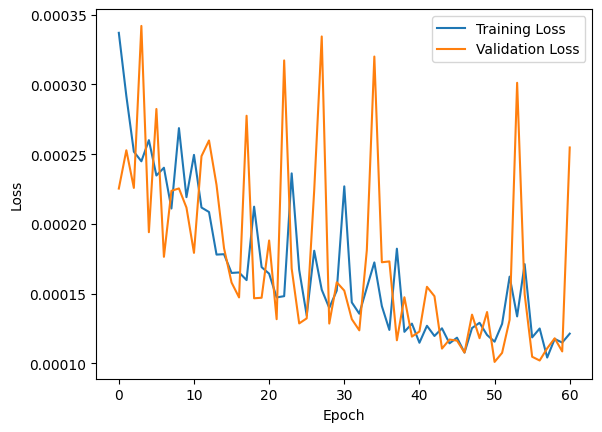

In [26]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Train the history model.

In [27]:
history = model.fit(X_train, y_train, batch_size=64 , epochs=50,validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
51/51 - 1s - 27ms/step - accuracy: 3.1124e-04 - loss: 1.3355e-04 - val_accuracy: 0.0012 - val_loss: 1.0658e-04
Epoch 2/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.0343e-04 - val_accuracy: 0.0012 - val_loss: 9.8993e-05
Epoch 3/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.1771e-04 - val_accuracy: 0.0012 - val_loss: 1.3436e-04
Epoch 4/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.1870e-04 - val_accuracy: 0.0012 - val_loss: 1.2060e-04
Epoch 5/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.4216e-04 - val_accuracy: 0.0012 - val_loss: 1.0124e-04
Epoch 6/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.0425e-04 - val_accuracy: 0.0012 - val_loss: 1.1087e-04
Epoch 7/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.0464e-04 - val_accuracy: 0.0012 - val_loss: 1.5970e-04
Epoch 8/50
51/51 - 1s - 26ms/step - accuracy: 3.1124e-04 - loss: 1.2299e-04 - val_accuracy: 0.0012 - val_loss: 1.2076e-04
Epoch 9/50
51/51 - 1s - 

## Evaluation: Evaluate model.

In [28]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Train Loss: [7.435255247401074e-05, 0.00031123560620471835]
Test Loss: [7.301972800632939e-05, 0.001243781065568328]


## Get the models predicted price values.

In [29]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Results: Calculate R2 score and MSE for testing data.

In [32]:
# Calculate R2 score and mean squared error for test set
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

# Calculate R2 score and mean squared error for train set
train_r2 = r2_score(y_train.reshape(-1), train_predictions.reshape(-1))
train_mse = mean_squared_error(y_train.reshape(-1), train_predictions.reshape(-1))

In [33]:
# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}') 

Training R2 Score: 0.999011571799511
Training Mean Squared Error: 7.435254834662066e-05
Testing R2 Score: 0.9990607715149767
Testing Mean Squared Error: 7.301973472336212e-05


## Saving model weights.

In [37]:
# Define the absolute path to the directory to save the model weights
weights_folder_path = r"F:\DataScience\code\stock-prediction\saved_models"

# Ensure that the directory exists, create it if it doesn't
os.makedirs(weights_folder_path, exist_ok=True)

# Define the filename with the desired suffix
weights_filename = "model_weights.weights.h5"

# Define the file path to save the model weights inside the folder
weights_file_path = os.path.join(weights_folder_path, weights_filename)

# Save the model weights
model.save_weights(weights_file_path)

print("Model weights saved successfully in the 'saved_models' folder.")

Model weights saved successfully in the 'saved_models' folder.


## Visualization: Plotting predictions.

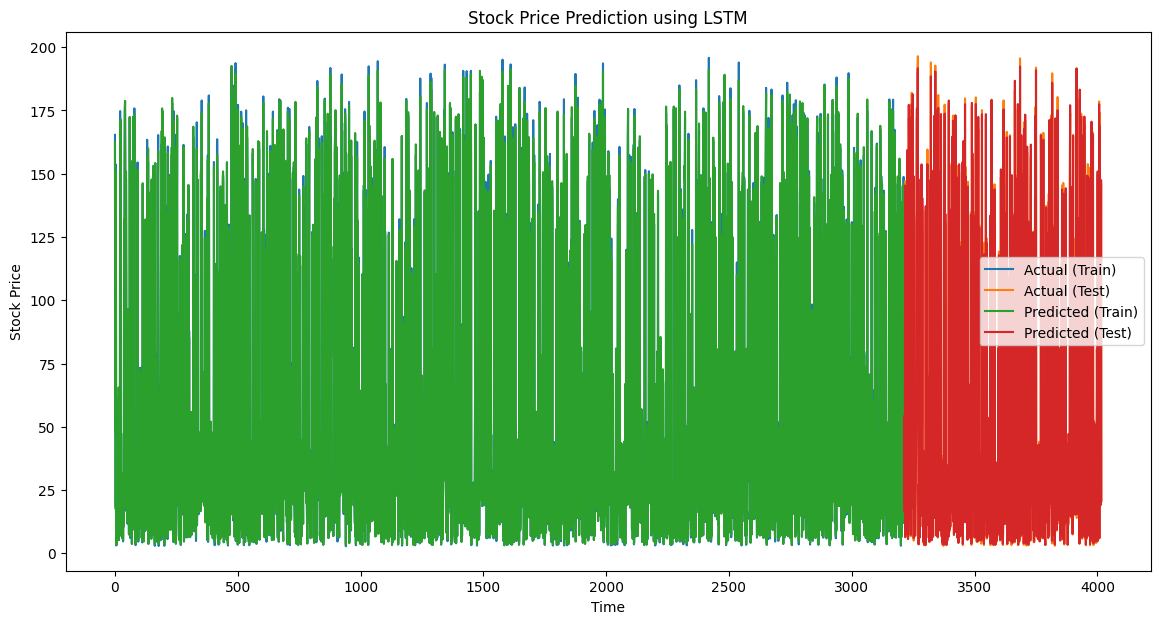

In [38]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [39]:
scaler.inverse_transform(y_train.reshape(-1, 1))
len(y_train) + len(y_test)

4017

## Visualization: Plotting training history.

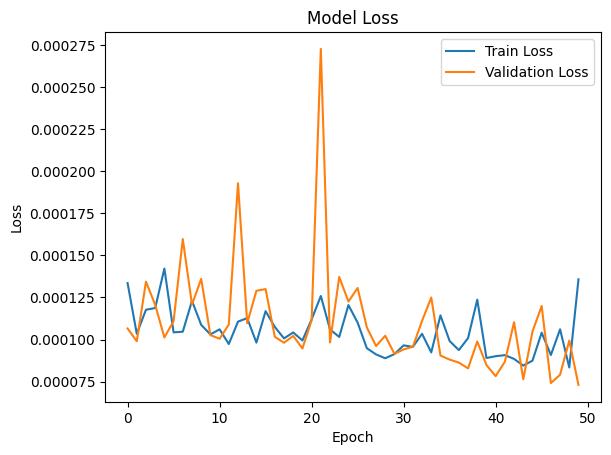

In [40]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make predictions.

In [41]:
y_pred = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## Inverse transform the predictions and actual values.

In [42]:
y_pred = scaler.inverse_transform(y_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [43]:
# Calculate R2 score
r2 = r2_score(y_test_orig, y_pred)
print("R2 Score:", r2)

R2 Score: 0.9990607716429466


In [44]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_orig, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.7384651546762426


## Plotting the actual vs. predicted values.

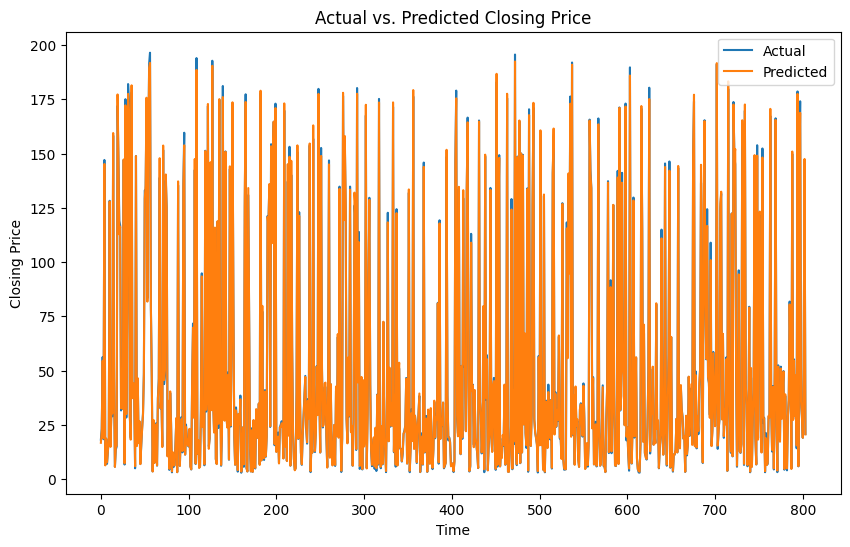

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Plot actual vs predicted closing prices.

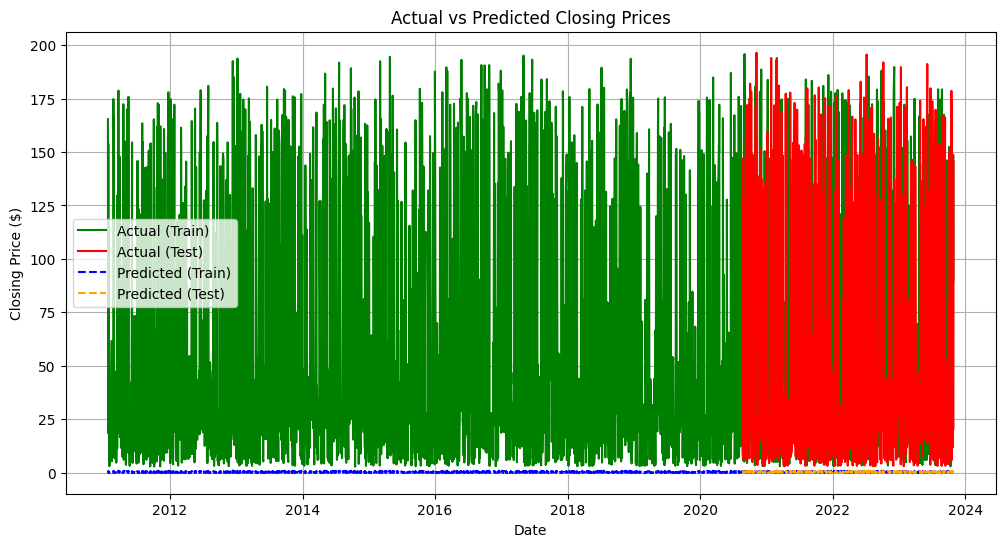

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_train_orig):], y_train_orig, label='Actual (Train)', color='green')
plt.plot(df['Date'][-len(y_test_orig):], y_test_orig, label='Actual (Test)', color='red')
plt.plot(df['Date'][-len(train_predictions):], train_predictions, label='Predicted (Train)', linestyle='--', color='blue')
plt.plot(df['Date'][-len(test_predictions):], test_predictions, label='Predicted (Test)', linestyle='--', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## Create a plot comparing actual, predicted, and closing prices.

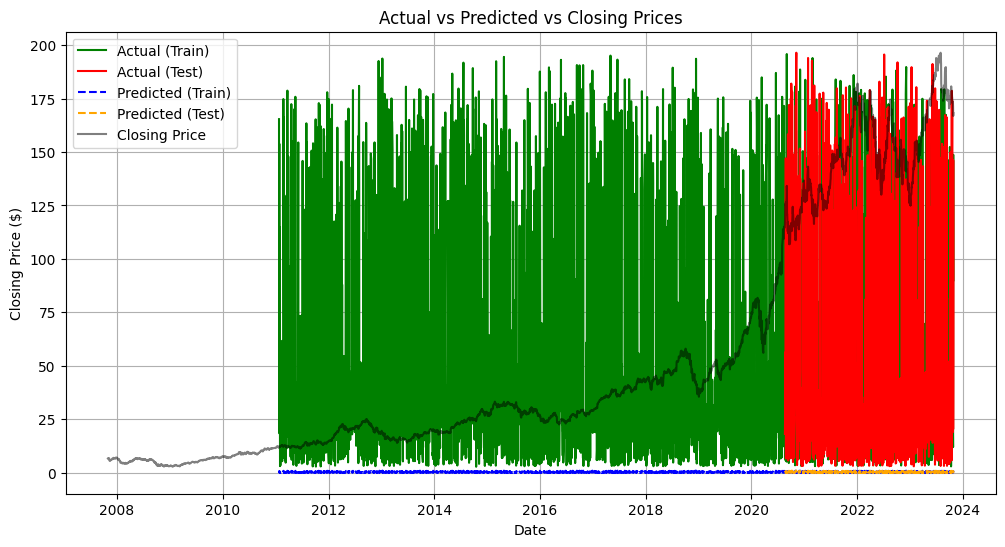

In [47]:
plt.figure(figsize=(12, 6))

# Plot actual closing prices
plt.plot(df['Date'][-len(y_train_orig):], y_train_orig, label='Actual (Train)', color='green')
plt.plot(df['Date'][-len(y_test_orig):], y_test_orig, label='Actual (Test)', color='red')

# Plot predicted closing prices
plt.plot(df['Date'][-len(train_predictions):], train_predictions, label='Predicted (Train)', linestyle='--', color='blue')
plt.plot(df['Date'][-len(test_predictions):], test_predictions, label='Predicted (Test)', linestyle='--', color='orange')

# Plot closing prices
plt.plot(df['Date'], df['Close'], label='Closing Price', color='black', alpha=0.5)

plt.title('Actual vs Predicted vs Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()


## Comparison: Plotting the Actual vs. Predicted Values using CNN vs LSTM.

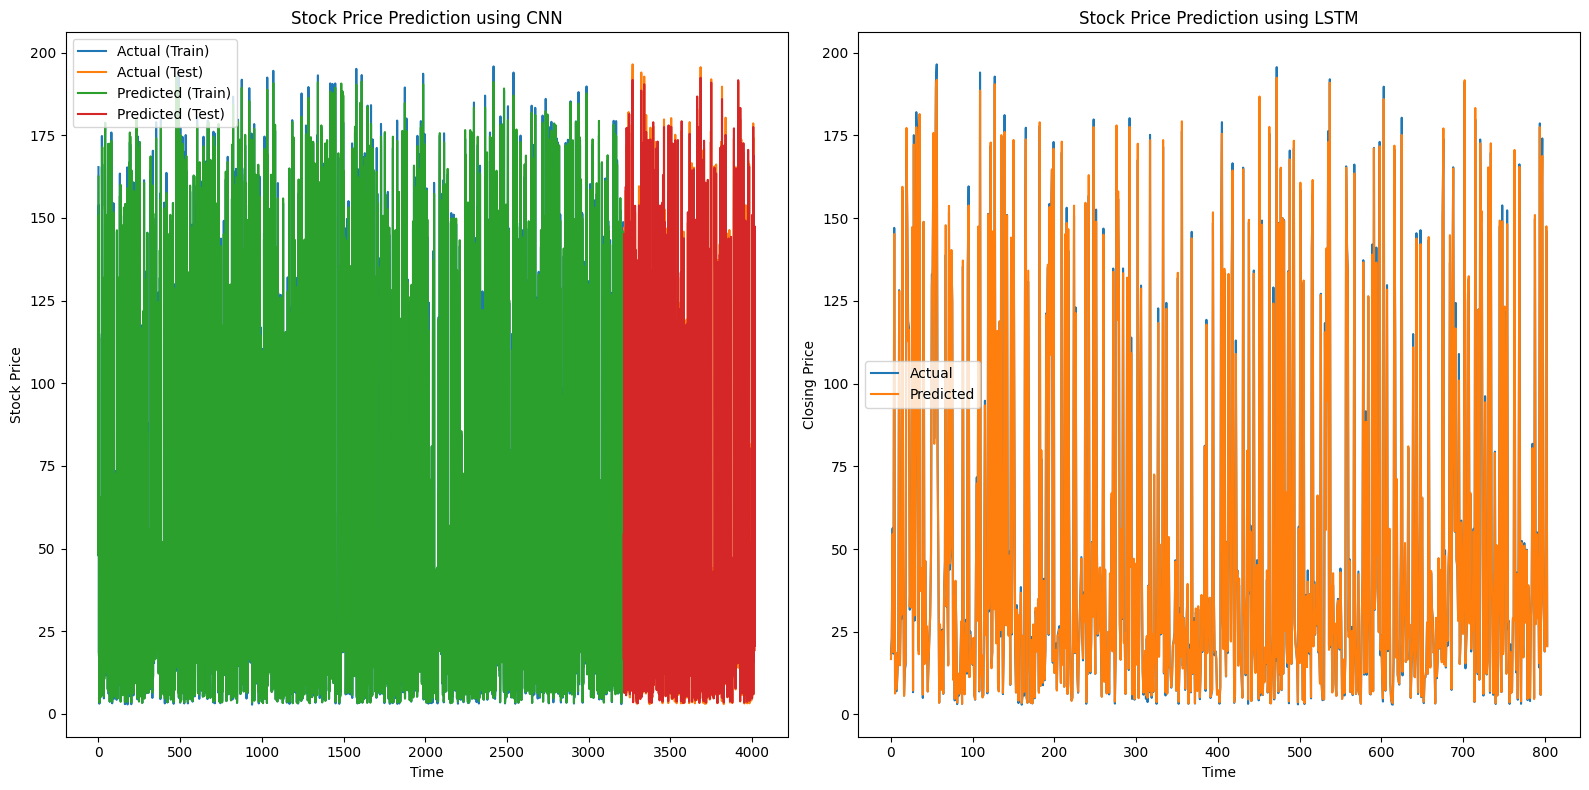

In [48]:
plt.figure(figsize=(16, 8))

# Plot predictions using CNN
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Plot predictions using the other method
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()


# Summary: Stock Prediction using LSTM Model.

### Introduction
The Long Short-Term Memory (LSTM) model is a type of recurrent neural network (RNN) that excels at capturing long-term dependencies in sequential data, making it well-suited for time series prediction tasks such as stock price forecasting.

### Model Architecture
Our LSTM model consists of multiple LSTM layers followed by a dense output layer. Each LSTM layer contains memory cells that retain information over time, allowing the model to learn complex patterns in the input sequences.

### Parameter Settings
- Number of LSTM units: 64
- Activation functions: tanh (for LSTM layers), linear (for output layer)
- Optimization algorithm: Adam

### Training Process
The LSTM model is trained on the training dataset after preprocessing steps such as data normalization. During training, the model minimizes the mean squared error loss function using the Adam optimizer.

### Evaluation
The trained LSTM model is evaluated on the test dataset to assess its performance. Performance metrics such as mean squared error (MSE) and R-squared are calculated to measure the model's accuracy in predicting stock prices.

### Results
The LSTM model demonstrates strong performance in predicting stock prices, as evidenced by low MSE and high R-squared values. Visualizations of the model's predictions compared to the actual values further illustrate its effectiveness.

### Conclusion
In conclusion, the LSTM model proves to be a powerful tool for stock price prediction, leveraging its ability to capture long-term dependencies in sequential data. Further experimentation and fine-tuning may yield even better results in real-world applications.
